# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** Theodor Tveit Husefest, Arlid Madshaven, Mathies Pollas Bjerg
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### MNIST 
*Add your implementation and discussion*

In [3]:
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.utils.data as data

In [4]:
def get_dataloaders(batch_size = 16, 
                    valid_size = 0.2,
                    shuffle= True):
    """
    Helper function to create online dataloaders to use in pytorch network.
    """
    transform = transforms.Compose([transforms.RandomRotation(180),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5), (0.5))])
    train_dataset = datasets.MNIST('MNIST_data/', download= True, train= True, transform = transform)
    
    test_dataset = datasets.MNIST('MNIST_data/', download= True, train= False, transform = transform)
    
    num_train = len(train_dataset)
    indicies = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    if shuffle:
        np.random.shuffle(indicies)
        
    train_ix, val_ix = indicies[split:], indicies[:split]
    train_sampler = data.SubsetRandomSampler(train_ix)
    val_sampler = data.SubsetRandomSampler(val_ix)
    
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler= train_sampler)
    val_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler= val_sampler)
    test_loader = data.DataLoader(test_dataset, batch_size = batch_size)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders()




In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self,).__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = 4, kernel_size= 3, padding= 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels= 4, out_channels = 8, kernel_size= 3, padding= 1)
        self.fc1 = nn.Linear(8*7*7, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 8*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(x)
    
net = Net()

In [6]:
def validate_on_dataloader(net, dataloader):
    """
    Returns accuracy on a given dataloader
    """
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():    
        for images, labels in val_loader:

            output = net(images)
            predicted = (F.softmax(output).data).max(1)[1]
            correct += (labels == predicted).sum().item()
            total += labels.size(0)

    return 100*(correct/total)

In [7]:
import time

epochs = 5
eval_every = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

for e in range(epochs):
    epoch_loss = 0
    accuracy = 0
    tic = time.time()
    net.train()
    
    print('--------------------------------------------------')
    print('EPOCH {}.'.format(e))

    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if e % eval_every == 0:
        accuracy = validate_on_dataloader(net, val_loader)
        print('Accuracy on validation set {}'.format(accuracy))


        
    toc = time.time()
    print('Finished epoch after {}s'.format(np.around(toc-tic, 3)))
    print('Loss after epoch {} was {}.'.format(e, epoch_loss))
    print('--------------------------------------------------\n')
    

--------------------------------------------------
EPOCH 0.
Accuracy on validation set 82.85833333333333
Finished epoch after 21.574s
Loss after epoch 0 was 2652.352029964328.
--------------------------------------------------

--------------------------------------------------
EPOCH 1.
Finished epoch after 19.299s
Loss after epoch 1 was 1195.18766342476.
--------------------------------------------------

--------------------------------------------------
EPOCH 2.
Accuracy on validation set 91.65833333333333
Finished epoch after 22.197s
Loss after epoch 2 was 890.5126202148385.
--------------------------------------------------

--------------------------------------------------
EPOCH 3.
Finished epoch after 19.411s
Loss after epoch 3 was 767.8573302775621.
--------------------------------------------------

--------------------------------------------------
EPOCH 4.
Accuracy on validation set 92.80000000000001
Finished epoch after 21.888s
Loss after epoch 4 was 680.3304076124914.
---

In [8]:
test_accuracy = validate_on_dataloader(net, test_loader)

print('Accuracy on testset:', test_accuracy)

Accuracy on testset: 93.25833333333333


Label: 9
Predicted: 9


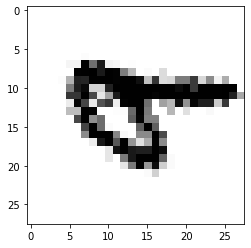

In [102]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
img_nr = np.random.randint(16, size = 1)
img, label = images[img_nr], labels[img_nr]

plt.imshow(img.resize(28,28), cmap = "Greys")
print('Label:', label.item())

output = net(img)
pred = (F.softmax(output).data).max(1)[1]
print('Predicted:', pred.item())

---
#### Thoughts on Task 2

As the group had more experience in PyTorch we chose to use this to implement the neural net, and it gave quite good performance.  
We see that the neural net is performing very good with quite low complexity, and if we were to add for example convolutional layers we would get even better performance.  
Compared to lab 2 where we had to pick out features and tune our algos, this is a lot easier and is probably performing a lot better than we could manage by doing this manually.

---

In [84]:
def theshold_test_img(img):
    img_mean = img.mean()
    img[img < img_mean] = 0
    img[img >= img_mean] = 255
    return img


Predicted: 5


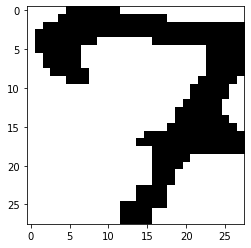

In [87]:
import PIL
from skimage.color import rgb2gray

img = PIL.Image.open("./data/candidates/im27.png")
img = PIL.ImageOps.invert(img)

img = img.resize((28, 28), PIL.Image.ANTIALIAS)
img = np.asarray(img)
img = rgb2gray(img)
img = theshold_test_img(img)

plt.imshow(img, cmap= "Greys")
img = torch.from_numpy(img.astype(np.float32))
img = img.unsqueeze(0)
img = img.unsqueeze(0)
output = net(img)
pred = (F.softmax(output).data).max(1)[1]
print('Predicted:', pred.item())